In [1]:
import sys
import os
from prody import parsePDB,calcTempFactors,parseMMCIF,confProDy
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
from Bio.PDB import *
from multiscale import MultiscaleGNM,MultiscaleANM,multiscale_gamma
from os import listdir
from collections import defaultdict
import pickle
import multiprocessing as mp
from functools import partial
from testmod import *
ion()

Structure exists: 'PDB/1aba.cif' 
Structure exists: 'PDB/1aho.cif' 
Structure exists: 'PDB/1aie.cif' 
Structure exists: 'PDB/1akg.cif' 
Structure exists: 'PDB/1atg.cif' 
Structure exists: 'PDB/1bgf.cif' 
Structure exists: 'PDB/1bx7.cif' 
Structure exists: 'PDB/1byi.cif' 
Structure exists: 'PDB/1ccr.cif' 
Structure exists: 'PDB/1cyo.cif' 
Structure exists: 'PDB/1df4.cif' 
Structure exists: 'PDB/1e5k.cif' 
Structure exists: 'PDB/1es5.cif' 
Structure exists: 'PDB/1etl.cif' 
Structure exists: 'PDB/1etm.cif' 
Structure exists: 'PDB/1etn.cif' 
Structure exists: 'PDB/1ew4.cif' 
Structure exists: 'PDB/1f8r.cif' 
Structure exists: 'PDB/1ff4.cif' 
Structure exists: 'PDB/1fk5.cif' 
Structure exists: 'PDB/1gco.cif' 
Structure exists: 'PDB/1gk7.cif' 
Structure exists: 'PDB/1gvd.cif' 
Structure exists: 'PDB/1gxu.cif' 
Structure exists: 'PDB/1h6v.cif' 
Structure exists: 'PDB/1hje.cif' 
Structure exists: 'PDB/1i71.cif' 
Structure exists: 'PDB/1idp.cif' 
Structure exists: 'PDB/1ifr.cif' 
Structure exis

In [2]:
confProDy(verbosity='none')
print("Number of processors: ", mp.cpu_count())

Number of processors:  96


## Build test engien

with open('pdbid.txt','r') as f:
    pdblist = f.read().split()

pdbl = PDBList()
for i in pdblist:
    pdbl.retrieve_pdb_file(i,pdir='PDB')

f_path = "./PDB/"
nameset = sort(list(set([l.split(".")[0] for l in listdir(f_path)])))

def getBfactor(structure):
    bfactor = []
    for i in structure.get_atoms():
        if i.get_name() == 'CA':
            bfactor.append(i.get_bfactor())
    bfactor = np.array(bfactor)
    return bfactor

def getMatrix(calpha,init_eta,kernel,model,i):
        eta = i+init_eta
        if model == 'mGNM': 
            nm = MultiscaleGNM()
            nm.buildKirchhoff(calpha,cutoff=9999, gamma=multiscale_gamma(eta=eta,v=3,kernel=kernel))
            return nm.getKirchhoff()
        elif model == 'mANM':
            nm = MultiscaleANM()
            nm.buildHessian(calpha,cutoff=9999, gamma=multiscale_gamma(eta=eta,v=3,kernel=kernel))
            return nm.getHessian()

def pccFromModel(calpha,bfactor,test_range,init_eta,kernel,model='mGNM'):
    pcc_grid = np.zeros((test_range,test_range))
    func = partial(getMatrix, calpha,init_eta,kernel,model)
    with mp.Pool(min(test_range,mp.cpu_count())) as pool:
        pre_build=pool.map(func,range(test_range))       
    #print(pre_build[0].shape)
    #print(size(bfactor))
    for i in range(test_range):
        for j in range(i,test_range):
            if i != j:
                mat = [pre_build[i],pre_build[j]]
            else:
                mat = [pre_build[i]]
            if model=='mGNM':
                nm = MultiscaleGNM()
                nm.buildMultiscaleKirchhoffFromKernels(mat,bfactor)
                nm.calcModes('all')
            elif model =='mANM':
                nm = MultiscaleANM()
                nm.buildMultiscaleHessianFromKernels(mat,bfactor)
                nm.calcModes('all')
            tempfluc = calcTempFactors(nm,calpha)
            pcc_grid[i,j] = pcc_grid[j,i] = np.corrcoef(tempfluc,bfactor)[0,1]
    return pcc_grid

# parrelization with multiproccess
test_range = 30
def pcc_pool(name,model,kernel):
    #print(name)
    parser = MMCIFParser()
    structure = parser.get_structure(name,f_path+name+'.cif')
    bfactor = getBfactor(structure)
    cur_str = parseMMCIF(f_path+name+'.cif')
    calpha = cur_str.select('name CA')
    if kernel == 'ilf':
        init_eta = 5
    else:
        init_eta = 1
    pcc=pccFromModel(calpha,bfactor,test_range=30,init_eta=init_eta,kernel=kernel,model=model)
    return pcc



In [3]:
precalc = len(nameset)

In [4]:
help(calc_save)

Help on function calc_save in module testmod:

calc_save(model, kernel, nameset, logfile='./logfile', exclude_long=1000)
    input:
        model: name of model, in the set ('mGNM','mANM')
        kernel: name of kernel, in the set ('exponential','lorenz','ilf')
        nameset: list of pdbid, the pdbid of pre-downloaded proteins
        logfile: the saved path of logfile
        exclude_long: the cut off size, above which the structure is excluded
    putput:
        pcc_total: a list of pcc matrices, order is the same as nameset
    save_path is the path to save precalculated data.
    file_path is the path individual matrix is saved.



In [5]:
model = 'mGNM'
kernel = 'exponential'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc1=np.average(pcc_total,axis=0)

[Errno 17] File exists: './result/mGNM_exponential/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


87 1yjo
88 1yzm
89 1z21
90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,


106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstructionWarning,


107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


125 2gzq
126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/li

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a
176 2w6a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,


177 2wj5
178 2wuj


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 973.
  PDBConstructionWarning,


179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3478.
  PDBConstr

180 2wwe
181 2x1q
182 2x25


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


189 2y7l
190 2y9f
191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,


193 2zcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstructionWarning,


194 2zu1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 929.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 102

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,


198 3aub
199 3b5o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


200 3ba1
201 3bed


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


202 3bqx
203 3bzq
204 3bzz


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,


205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,


212 3fcn
213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,


215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 356.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 361.
  PDBConstructio

218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s
221 3gbw
222 3ghj
223 3hfo


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,


224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9857.
  PDBConstructionWarning,


skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,


232 3i4o
233 3i7m
234 3ihs


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1468.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk
239 3kzd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,


240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,


247 3m9j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


248 3m9q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,


249 3mab
250 3md4
251 3md5
252 3mea


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 97.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 93.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 96.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1317.
  PDBConstructionWa

253 3mgn
254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg
258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

264 3oqy
265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


267 3pes
268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,


273 3pve


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2788.
  PDBConstructionWarning,


274 3pz9
275 3pzz
276 3q2x
277 3q6l
278 3qds


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


279 3qpa
280 3r6d
281 3r87
282 3rq9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


283 3ry0
284 3rzy
285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6
290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,


291 3suk
292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1998.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


308 3vor
309 3vub
310 3vvv
311 3vz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,


312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,


314 3zit


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


315 3zrx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


316 3zsl
317 3zzp
318 3zzy
319 4a02


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8842.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9235.
  PDBConstructionWarning,


327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery
336 4es1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,


345 4g7x
346 4ga2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,


356 4j5o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2070.
  PDBConstructionWarning,


357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu
361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


model = 'mGNM'
kernel = 'exponential'
namepair = (9, '1ccr')
name = namepair[1]
print(namepair)
parser = MMCIFParser()
structure = parser.get_structure(name,f_path+name+'.cif')
bfactor = getBfactor(structure)
cur_str = parseMMCIF(f_path+name+'.cif')
calpha = cur_str.select('name CA')
if kernel == 'ilf':
    init_eta = 5
else:
    init_eta = 1
pcc=pccFromModel(calpha,bfactor,test_range=30,init_eta=init_eta,kernel=kernel,model=model)

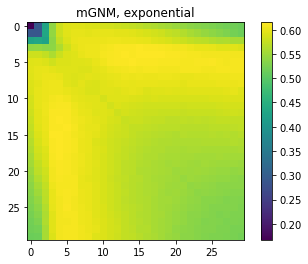

In [6]:

plt.imshow(pcc_acc1)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

In [7]:
np.unravel_index(np.argmax(pcc_acc1), pcc_acc1.shape)

(4, 15)

In [8]:
np.max(pcc_acc1)

0.6152148736899801

In [9]:
model = 'mGNM'
kernel = 'lorentz'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc2=np.average(pcc_total,axis=0)

[Errno 17] File exists: './result/mGNM_lorentz/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


87 1yjo
88 1yzm
89 1z21
90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,


106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstructionWarning,


107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


125 2gzq
126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/li

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a
176 2w6a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstru

177 2wj5
178 2wuj
179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3478.
  PDBConstr

180 2wwe
181 2x1q
182 2x25


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,


189 2y7l
190 2y9f


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstr

193 2zcm
194 2zu1
195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


198 3aub
199 3b5o
200 3ba1
201 3bed
202 3bqx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


203 3bzq
204 3bzz
205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,


212 3fcn
213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstruct

215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning,


218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s
221 3gbw
222 3ghj
223 3hfo


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,


224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9857.
  PDBConstructionWarning,


skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z
232 3i4o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,


233 3i7m
234 3ihs


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1468.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk
239 3kzd
240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


247 3m9j
248 3m9q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,


249 3mab


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 97.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 93.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 96.
  PDBConstructionWa

250 3md4
251 3md5
252 3mea
253 3mgn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3169.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3267.
  PDBConstr

254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,


258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq
264 3oqy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


267 3pes
268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,


273 3pve


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2788.
  PDBConstructionWarning,


274 3pz9
275 3pzz
276 3q2x
277 3q6l
278 3qds


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


279 3qpa
280 3r6d
281 3r87
282 3rq9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


283 3ry0
284 3rzy
285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6
290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstr

291 3suk
292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5941.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6078.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


308 3vor
309 3vub
310 3vvv
311 3vz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,


312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


314 3zit
315 3zrx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


316 3zsl
317 3zzp
318 3zzy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


319 4a02
320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8842.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9235.
  PDBConstructionWarning,


327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery
336 4es1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


345 4g7x
346 4ga2
347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstr

356 4j5o
357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,


361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


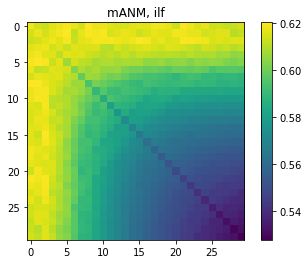

In [29]:

plt.imshow(pcc_acc2)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

### This is a mutiscale NMA test notebook


In [11]:
np.unravel_index(np.argmax(pcc_acc2), pcc_acc2.shape)

(1, 5)

In [12]:
np.max(pcc_acc2)

0.6202088981900818

In [13]:
model = 'mGNM'
kernel = 'ilf'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc3=np.average(pcc_total,axis=0)  

[Errno 17] File exists: './result/mGNM_ilf/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x
87 1yjo
88 1yzm
89 1z21


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,


106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstructionWarning,


107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


125 2gzq
126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/li

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a
176 2w6a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstru

177 2wj5
178 2wuj
179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3478.
  PDBConstr

180 2wwe
181 2x1q
182 2x25


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,


189 2y7l
190 2y9f


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstr

193 2zcm
194 2zu1
195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


198 3aub
199 3b5o
200 3ba1
201 3bed
202 3bqx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


203 3bzq
204 3bzz
205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,


212 3fcn
213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstruct

215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning,


218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:54: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(diag_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s
221 3gbw
222 3ghj
223 3hfo


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,


224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9857.
  PDBConstructionWarning,


skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z
232 3i4o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,


233 3i7m
234 3ihs


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1468.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk
239 3kzd
240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


247 3m9j
248 3m9q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,


249 3mab


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 97.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 93.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 96.
  PDBConstructionWa

250 3md4
251 3md5
252 3mea
253 3mgn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3169.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3267.
  PDBConstr

254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,


258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

264 3oqy
265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


267 3pes
268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,


273 3pve


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2788.
  PDBConstructionWarning,


274 3pz9
275 3pzz
276 3q2x
277 3q6l
278 3qds


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


279 3qpa
280 3r6d
281 3r87
282 3rq9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


283 3ry0
284 3rzy
285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6
290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstr

291 3suk
292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5941.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6078.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


308 3vor
309 3vub
310 3vvv
311 3vz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,


312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


314 3zit
315 3zrx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


316 3zsl
317 3zzp
318 3zzy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


319 4a02
320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8842.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9235.
  PDBConstructionWarning,


327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery
336 4es1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


345 4g7x
346 4ga2
347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstr

356 4j5o
357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,


361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


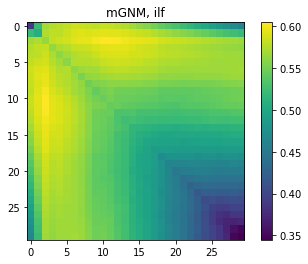

In [14]:

plt.imshow(pcc_acc3)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

In [15]:
np.unravel_index(np.argmax(pcc_acc3), pcc_acc3.shape)

(2, 11)

In [16]:
np.max(pcc_acc3)

0.6044919376145885

In [17]:
model = 'mANM'
kernel = 'lorentz'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc4=np.average(pcc_total,axis=0)  

[Errno 17] File exists: './result/mANM_lorentz/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


87 1yjo
88 1yzm
89 1z21
90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,


106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstructionWarning,


107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


125 2gzq
126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a
176 2w6a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,


177 2wj5
178 2wuj


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 973.
  PDBConstructionWarning,


179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3478.
  PDBConstr

180 2wwe
181 2x1q
182 2x25


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,


189 2y7l


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


190 2y9f
191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstr

193 2zcm
194 2zu1
195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


198 3aub
199 3b5o
200 3ba1
201 3bed
202 3bqx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


203 3bzq
204 3bzz
205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e
212 3fcn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,


213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstruct

215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning,


218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s
221 3gbw
222 3ghj
223 3hfo


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,


224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9857.
  PDBConstructionWarning,


skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z
232 3i4o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,


233 3i7m
234 3ihs


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1468.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk
239 3kzd
240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j
247 3m9j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


248 3m9q
249 3mab


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstruc

250 3md4
251 3md5
252 3mea
253 3mgn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1317.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1473.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3169.
  PDBConstr

254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg
258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq
264 3oqy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


267 3pes
268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,


273 3pve
274 3pz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2788.
  PDBConstructionWarning,


275 3pzz
276 3q2x
277 3q6l
278 3qds


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


279 3qpa
280 3r6d
281 3r87
282 3rq9
283 3ry0
284 3rzy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,


290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,


291 3suk
292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1998.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0
308 3vor


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


309 3vub
310 3vvv
311 3vz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,


312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


314 3zit
315 3zrx
316 3zsl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


317 3zzp
318 3zzy
319 4a02


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8842.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9235.
  PDBConstructionWarning,


327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery
336 4es1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


345 4g7x
346 4ga2
347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstr

356 4j5o
357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,


361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


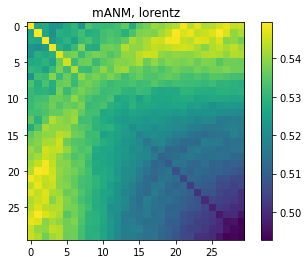

In [18]:

plt.imshow(pcc_acc4)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

In [19]:
np.unravel_index(np.argmax(pcc_acc4), pcc_acc4.shape)

(0, 0)

In [20]:
np.max(pcc_acc4)

0.5494124792868652

In [21]:
model = 'mANM'
kernel = 'exponential'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc5=np.average(pcc_total,axis=0)  

[Errno 17] File exists: './result/mANM_exponential/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


87 1yjo
88 1yzm
89 1z21
90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko
106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstr

107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg
125 2gzq


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,


176 2w6a
177 2wj5
178 2wuj


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 973.
  PDBConstructionWarning,


179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3478.
  PDBConstr

180 2wwe
181 2x1q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


182 2x25
183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


189 2y7l
190 2y9f
191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstr

193 2zcm
194 2zu1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 929.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 102

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,


198 3aub


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


199 3b5o
200 3ba1
201 3bed
202 3bqx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


203 3bzq
204 3bzz
205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e
212 3fcn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,


213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstruct

215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning,


218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


221 3gbw
222 3ghj
223 3hfo
224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstr

skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z
232 3i4o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstr

233 3i7m
234 3ihs
235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,


239 3kzd
240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j
247 3m9j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


248 3m9q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstruc

249 3mab
250 3md4
251 3md5
252 3mea


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1317.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1473.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3169.
  PDBConstr

253 3mgn
254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg
258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq
264 3oqy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,


267 3pes


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstruc

273 3pve
274 3pz9
275 3pzz
276 3q2x
277 3q6l
278 3qds


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


279 3qpa
280 3r6d
281 3r87
282 3rq9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


283 3ry0
284 3rzy
285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6
290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,


291 3suk


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1998.
  PDBConstructionWarning,


292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5941.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6078.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0
308 3vor


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


309 3vub
310 3vvv
311 3vz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,


312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


314 3zit
315 3zrx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


316 3zsl
317 3zzp
318 3zzy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


319 4a02
320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8842.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9235.
  PDBConstructionWarning,


327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery
336 4es1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,


345 4g7x
346 4ga2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstr

356 4j5o
357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,


361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


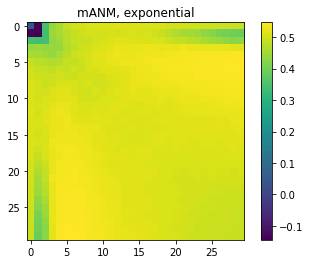

In [22]:

plt.imshow(pcc_acc5)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

In [23]:
np.unravel_index(np.argmax(pcc_acc5), pcc_acc5.shape)

(5, 29)

In [24]:
np.max(pcc_acc5)

0.5469510058390205

In [25]:
model = 'mANM'
kernel = 'ilf'
# with mp.Pool(mp.cpu_count()) as pool:
#     pcc_total = pool.starmap(pcc_pool, [(pair,model,kernel) for pair in enumerate(nameset)])


pcc_total = calc_save(model,kernel,nameset[:precalc],exclude_long = 1000)
pcc_acc6=np.average(pcc_total,axis=0)  


[Errno 17] File exists: './result/mANM_ilf/'
0 1aba
1 1agn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11156.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11215.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11280.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11388.
  PDBC

skipped
2 1aho
3 1aie
4 1akg
5 1atg
6 1bgf
7 1bx7
8 1byi
9 1ccr
10 1cyo
11 1df4
12 1e5k
13 1es5
14 1etl
15 1etm
16 1etn
17 1ew4
18 1f8r


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15523.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15603.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15683.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15763.
  PDBC

skipped
19 1ff4
20 1fk5
21 1gco


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7888.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7932.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7976.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 8020.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8064.
  PDBConstr

skipped
22 1gk7
23 1gvd
24 1gxu
25 1h6v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22606.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22698.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22790.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22882.
  PDBC

skipped
26 1hje
27 1i71
28 1idp
29 1ifr
30 1k8u
31 1kmm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14289.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14369.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14409.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14449.
  PDBC

skipped
32 1kng
33 1kr4
34 1kyc
35 1lr7
36 1mf7
37 1n7e
38 1nkd
39 1nko


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)


Input contains NaN, infinity or a value too large for dtype('float64').
40 1nls
41 1nnx
42 1noa
43 1not
44 1o06
45 1o08
46 1ob4
47 1ob7
Found input variables with inconsistent numbers of samples: [16, 17]
48 1opd
49 1p9i
50 1pef
51 1pen
52 1pmy
53 1pz4
54 1q9b
55 1qau
56 1qki


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31154.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31207.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31272.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 31331.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31384.
  PDBC

skipped
57 1qto
58 1r29
59 1r7j
60 1rju
61 1rro
62 1sau
63 1tgr


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 956.
  PDBConstructionWarning,


64 1tzv
65 1u06
66 1u7i


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2136.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2320.
  PDBConstructionWarning,


67 1u9c
68 1uha
69 1uku
70 1ulr
71 1uoy
72 1use
73 1usm
74 1utg
75 1v05
76 1v70
77 1vrz
78 1w2l
79 1wbe
80 1whi
81 1wly
82 1wpa
83 1x3o
84 1xy1
85 1xy2
86 1y6x
87 1yjo
88 1yzm
89 1z21


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 266.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 272.
  PDBConstructionWarning,


90 1zce
91 1zva
92 2a50


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3731.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3840.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4077.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4162.
  PDBConstructionWarning,


93 2agk
94 2ah1


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 7462.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7664.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8375.
  PDBConstructionWarning,


95 2b0a
96 2bcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3135.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3298.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3452.
  PDBConstructionWarning,


97 2bf9
98 2brf
99 2c71
100 2ce0
101 2cg7
102 2cov


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4481.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4591.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4676.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4763.
  PDBConstr

103 2cws
104 2d5w


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10340.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10841.
  PDBConstructionWarning,


skipped
105 2dko
106 2dpl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2092.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2311.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2420.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4500.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4993.
  PDBConstr

107 2dsx
108 2e10


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3697.
  PDBConstructionWarning,


109 2e3h
110 2eaq
111 2ehp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1891.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1964.
  PDBConstructionWarning,


112 2ehs
113 2erw
114 2etx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3018.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3222.
  PDBConstructionWarning,


115 2fb6
116 2fg1
117 2fn9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4362.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4692.
  PDBConstructionWarning,


118 2fq3
119 2g69
120 2g7o
121 2g7s
122 2gkg
123 2gom
124 2gxg
125 2gzq


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 987.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1069.
  PDBConstructionWarning,


126 2hqk
127 2hyk
128 2i24
129 2i49
130 2ibl
131 2igd
132 2imf
133 2ip6
134 2ivy
135 2j32


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1971.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2269.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1650.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1722.
  PDBConstructionWarning,


136 2j9w
137 2jku
138 2jli
139 2jlj
140 2mcm
141 2nls
142 2nr7
143 2nuh
144 2o6x
145 2oa2
146 2oct


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1570.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/

Input contains NaN, infinity or a value too large for dtype('float64').
147 2ohw
148 2okt
149 2ol9
150 2olx
151 2pkt
152 2plt
153 2pmr
154 2pof


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3514.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3676.
  PDBConstructionWarning,


155 2ppn
156 2psf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4983.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  PDBConstructionWarning,


157 2pth
158 2q4n
Found input variables with inconsistent numbers of samples: [181, 1224]
159 2q52


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3348.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3549.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7080.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10812.
  PDBConst

Found input variables with inconsistent numbers of samples: [480, 3296]
160 2qjl
161 2r16
162 2r6q
163 2rb8
164 2re2


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1898.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2061.
  PDBConstructionWarning,


165 2rfr
166 2v9v
167 2ve8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3972.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4066.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4158.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4247.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4328.
  PDBConstr

168 2vh7
169 2vim
170 2vpa
171 2vq4
172 2vy8
173 2vyo
174 2w1v


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4273.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4653.
  PDBConstructionWarning,


175 2w2a
176 2w6a


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2918.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3189.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1040.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1120.
  PDBConstructionWarning,


177 2wj5
178 2wuj
179 2ww7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 856.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 973.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3173.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3249.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3340.
  PDBConstruc

180 2wwe
181 2x1q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1852.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2084.
  PDBConstructionWarning,


182 2x25
183 2x3m
184 2x5y
185 2x9z
186 2xhf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4871.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5041.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 838.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 900.
  PDBConstructionWarning,


187 2y0t
188 2y72


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1323.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1499.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2426.
  PDBConstructionWarning,


189 2y7l


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2729.
  PDBConstructionWarning,


190 2y9f
191 2ylb


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6921.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6981.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7048.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7113.
  PDBConstr

192 2yny


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2571.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2654.
  PDBConstructionWarning,


193 2zcm


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3031.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3493.
  PDBConstructionWarning,


194 2zu1
195 3a0m


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2794.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3123.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 14, ' ') redefined at line 827.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:130: PDBConstructionWarning: WARNING: Residue (' ', 17, ' ') redefined at line 864.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9

Found input variables with inconsistent numbers of samples: [148, 150]
196 3a7l
197 3amc


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5174.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5546.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 902.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1028.
  PDBConstructionWarning,


198 3aub
199 3b5o
200 3ba1
201 3bed


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2025.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2197.
  PDBConstructionWarning,


202 3bqx
203 3bzq
204 3bzz
205 3drf


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 799.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 821.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4397.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5508.
  PDBConstructionWarning,


206 3dwv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2780.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2951.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [325, 326]
207 3e5t
208 3e7r
209 3eur
210 3f2z
211 3f7e


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2148.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2329.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 752.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 820.
  PDBConstructionWarning,


212 3fcn
213 3fe7
214 3fke


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1938.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2043.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 328.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 339.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 346.
  PDBConstruct

215 3fmy
216 3fod
217 3fso


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3803.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3945.
  PDBConstructionWarning,


218 3ftd
219 3fva


/wsu/home/fr/fr15/fr1583/K/NMAcomp/multiscale.py:88: RuntimeWarning: divide by zero encountered in true_divide
  reg.fit(mu_n.T,1/bfactor)
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3196.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3356.
  PDBConstructionWarning,


Input contains NaN, infinity or a value too large for dtype('float64').
220 3g1s
221 3gbw
222 3ghj
223 3hfo


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1630.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1730.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1825.
  PDBConstructionWarning,


224 3hhp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9464.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9583.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9714.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9857.
  PDBConstructionWarning,


skipped
225 3hny
226 3hp4
227 3hwu
228 3hyd
229 3hz8
230 3i2v
231 3i2z
232 3i4o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1073.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1106.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1255.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1352.
  PDBConstructionWarning,


233 3i7m
234 3ihs


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1468.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


235 3ivv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1286.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1487.
  PDBConstructionWarning,


Found input variables with inconsistent numbers of samples: [149, 150]
236 3k6y
237 3kbe
238 3kgk
239 3kzd
240 3l41


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1492.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1629.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1745.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2150.
  PDBConstructionWarning,


241 3laa
242 3lax
243 3lg3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6699.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7316.
  PDBConstructionWarning,


244 3lji
245 3m3p
246 3m8j
247 3m9j


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1396.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1463.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1955.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2057.
  PDBConstructionWarning,


248 3m9q
249 3mab


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1577.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1849.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1417.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1519.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 91.
  PDBConstruc

250 3md4
251 3md5
252 3mea
253 3mgn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1317.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1473.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3038.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3169.
  PDBConstr

254 3mre


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3678.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4160.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 4348.
  PDBConstructionWarning,


255 3n11
256 3ne0
257 3ngg
258 3npv


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 732.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 797.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3711.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3856.
  PDBConstructionWarning,


259 3nvg
260 3nzl
261 3o0p
262 3o5p
263 3obq
264 3oqy


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1195.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1384.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 1848.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1885.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 2033.
  PDBConstr

265 3p6j
266 3pd7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3587.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1342.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1505.
  PDBConstructionWarning,


267 3pes
268 3pid
269 3piw
270 3pkv
271 3psm
272 3ptl


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 772.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 859.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2101.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2532.
  PDBConstructionWarning,


273 3pve
274 3pz9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2656.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2788.
  PDBConstructionWarning,


275 3pzz
276 3q2x
277 3q6l


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 76.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 79.
  PDBConstructionWarning,


278 3qds
279 3qpa


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2240.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2352.
  PDBConstructionWarning,


280 3r6d
281 3r87
282 3rq9


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1363.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1459.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 964.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1052.
  PDBConstructionWarning,


283 3ry0
284 3rzy
285 3s0a
286 3sd2
287 3seb
288 3sed
Found input variables with inconsistent numbers of samples: [124, 125]
289 3so6
290 3sr3


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1217.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain Q is discontinuous at line 1383.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5075.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5427.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1803.
  PDBConstr

291 3suk
292 3szh


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5510.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5665.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5805.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5941.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6078.
  PDBConstr

293 3t0h
294 3t3k
295 3t47


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2374.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2472.
  PDBConstructionWarning,


296 3tdn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2735.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2819.
  PDBConstructionWarning,


297 3tow
298 3tua
299 3tys
300 3u6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2011.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2112.
  PDBConstructionWarning,


301 3u97
302 3uci
303 3ur8


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5131.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5559.
  PDBConstructionWarning,


304 3us6
305 3v1a
306 3v75
307 3vn0
308 3vor


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1690.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1746.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1814.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1878.
  PDBConstructionWarning,


309 3vub
310 3vvv
311 3vz9
312 3w4q


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1366.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1527.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6039.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6338.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6650.
  PDBConstr

Found input variables with inconsistent numbers of samples: [773, 774]
313 3zbd


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1718.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1839.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1260.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1283.
  PDBConstructionWarning,


314 3zit
315 3zrx


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1853.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1983.
  PDBConstructionWarning,


316 3zsl
317 3zzp
318 3zzy
319 4a02


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1741.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1846.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 1925.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1930.
  PDBConstructionWarning,


320 4acj
321 4ae7
322 4am1
323 4ann
324 4avr
325 4axy
326 4b6g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1455.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1565.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 716.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 744.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 765.
  PDBConstruct

327 4b9g


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4378.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4632.
  PDBConstructionWarning,


328 4dd5
329 4dkn


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3394.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3649.
  PDBConstructionWarning,


330 4dnd
331 4dpz
Found input variables with inconsistent numbers of samples: [109, 110]
332 4dq7


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5214.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5376.
  PDBConstructionWarning,


333 4dt4
334 4ek3
335 4ery


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2457.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 2961.
  PDBConstructionWarning,


336 4es1
337 4eug
338 4f01


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3472.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  PDBConstructionWarning,


339 4f3j
340 4fr9
341 4g14
342 4g2e
343 4g5x


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4430.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4890.
  PDBConstructionWarning,


344 4g6c


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5008.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5343.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1658.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1762.
  PDBConstructionWarning,


345 4g7x
346 4ga2
347 4gmq
348 4gs3
349 4h4j
350 4h89
351 4hde
352 4hjp
353 4hwm
354 4il7
355 4j11


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2946.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3062.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3200.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3304.
  PDBConstructionWarning,


356 4j5o


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1959.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2070.
  PDBConstructionWarning,


357 4j5q
358 4j78


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2443.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2774.
  PDBConstructionWarning,


359 4jg2
360 4jvu


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1615.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1775.
  PDBConstructionWarning,


361 4jyp


/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4233.
  PDBConstructionWarning,
/wsu/home/fr/fr15/fr1583/.conda/envs/protein/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4625.
  PDBConstructionWarning,


362 4kef
363 5cyt
364 6rxn


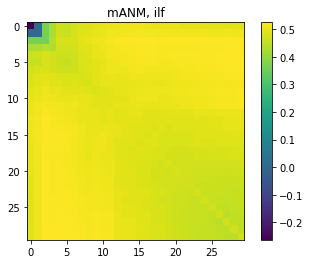

In [26]:
plt.imshow(pcc_acc6)
plt.colorbar()
plt.title(f'{model}, {kernel}')
plt.show()

In [27]:
np.unravel_index(np.argmax(pcc_acc6), pcc_acc6.shape)

(2, 28)

In [28]:
np.max(pcc_acc6)

0.5243221824084151